In [1]:
import numpy as np
import pandas as pd
from methods import GuptaPPCA
from methods import GrassPPCA
from methods import KernelPPCA
from methods import binPCA
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 100)
def F(a, b, c, d):
  return b*np.exp(-100*(x-a/2)**2) + c*np.exp(-100*(x+a/2)**2) + 1e-1*d*np.sin(np.pi*x)

def sampler(seed):
  np.random.seed(seed)
  a, b, c, d = 2*np.random.rand(4)-1
  u = F(a, b, c, d)
  return a, u

data = {'theta':[]}
data.update({'u%d' % (i+1):[] for i in range(len(x))})

for seed in range(500):
  a, u = sampler(seed)
  data['theta'].append(a)
  for i in range(len(x)):
    data['u%d' % (i+1)].append(u[i])

data = pd.DataFrame(data)
xdata = data.values[:,1:]
thetadata = data['theta'].values

In [2]:
data_test = {'theta':[]}
data_test.update({'u%d' % (i+1):[] for i in range(len(x))})

for seed in range(500):
  a, u = sampler(seed+500)
  data_test['theta'].append(a)
  for i in range(len(x)):
    data_test['u%d' % (i+1)].append(u[i])

data_test = pd.DataFrame(data_test)
xdata_test = data_test.values[:,1:]
thetadata_test = data_test['theta'].values

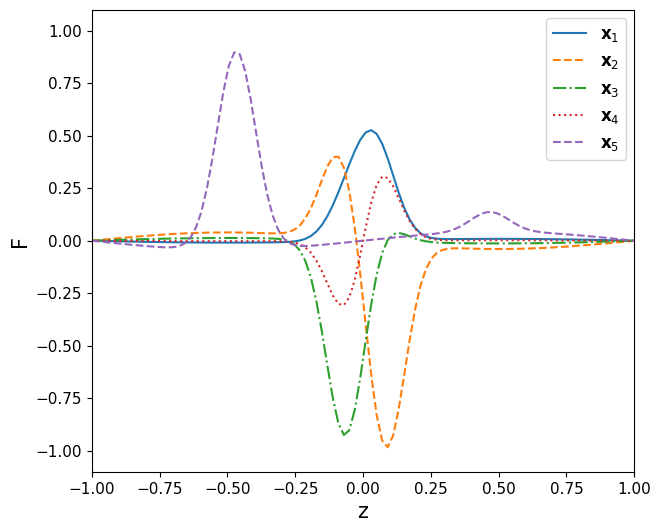

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,6))
lines = ['-','--','-.',':','--','--']
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
for j in range(5):
  plt.plot(x, data.iloc[j, 1:],lines[j],label= "$\\mathbf{x}_{%d}$" % (j+1))
plt.axis([-1, 1, -1.10, 1.10])
plt.xlabel('z')
plt.ylabel('F')
plt.legend()
plt.show()

In [4]:
bins = np.linspace(-1, 1, 5)
m = 3

In [5]:
# Standard PCA
pca = PCA(n_components=m)
data_red_PCA = pca.fit_transform(xdata)
data_PCA = pca.inverse_transform(data_red_PCA)

proj_test_PCA = pca.transform(xdata_test)
data_test_PCA = pca.inverse_transform(proj_test_PCA)

# Sparse PCA
spca = SparsePCA(n_components=m).fit(xdata)
spca_transf = spca.transform(xdata)
data_SPCA = (spca_transf @ spca.components_) + spca.mean_

proj_test_SPCA = spca.transform(xdata_test)
data_test_SPCA = (proj_test_SPCA @ spca.components_) + spca.mean_

# IPCA
ipca = binPCA(bins,m)
ipca.fit(thetadata,xdata)
proj_IPCA = ipca.transform(thetadata,xdata)
data_IPCA = ipca.inverse_transform(thetadata,proj_IPCA)

proj_test_IPCA = ipca.transform(thetadata_test,xdata_test)
data_test_IPCA = ipca.inverse_transform(thetadata_test,proj_test_IPCA)

# PPCA
gupta = GuptaPPCA(bins,m)
gupta.fit(thetadata,xdata,maxiter=500,method="Nelder-Mead")
proj_PPCA = gupta.transform(thetadata,xdata)
data_PPCA = gupta.inverse_transform(thetadata,proj_PPCA)

proj_test_PPCA = gupta.transform(thetadata_test,xdata_test)
data_test_PPCA = gupta.inverse_transform(thetadata_test,proj_test_PPCA)

# Kernel PCA
def kernel(theta_new, theta_i, gamma=8):
    return np.exp(-gamma*((theta_new-theta_i)**2))

kerpca = KernelPPCA(thetadata,xdata,m, kernel)
proj_ker = kerpca.transform(thetadata,xdata)
data_ker = kerpca.inverse_transform(thetadata,proj_ker)

proj_test_ker = kerpca.transform(thetadata_test,xdata_test)
data_test_ker = kerpca.inverse_transform(thetadata_test,proj_test_ker)

# Interpolation PCA
grass = GrassPPCA(bins,m)
grass.fit(thetadata,xdata)
proj_grass = grass.transform(thetadata,xdata)
data_grass = grass.inverse_transform(thetadata,proj_grass)

proj_test_grass = grass.transform(thetadata_test,xdata_test)
data_test_grass = grass.inverse_transform(thetadata_test,proj_test_grass)
names = ['PCA','SPCA','binPCA','PPCA','Grass','Kernel']
for name,xrec in zip(names,[data_test_PCA, data_test_SPCA, data_test_IPCA, data_test_PPCA, data_test_grass, data_test_ker]):
    print("%s : %.4f" % (name,np.sqrt(mean_squared_error(xdata_test, xrec))))


PCA : 0.1276
SPCA : 0.1318
binPCA : 0.0826
PPCA : 0.1086
Grass : 0.0763
Kernel : 0.0641


In [6]:
grass = GrassPPCA(np.linspace(-1,1,5),m)
grass.fit(thetadata,xdata)

proj_test_grass = grass.transform(thetadata_test,xdata_test)
data_test_grass = grass.inverse_transform(thetadata_test,proj_test_grass)

for name,xrec in zip(names,[data_test_PCA, data_test_SPCA, data_test_IPCA, data_test_PPCA, data_test_grass, data_test_ker]):
    print("%s : %.4f" % (name,np.sqrt(mean_squared_error(xdata_test, xrec))))

PCA : 0.1276
SPCA : 0.1318
binPCA : 0.0826
PPCA : 0.1086
Grass : 0.0763
Kernel : 0.0641


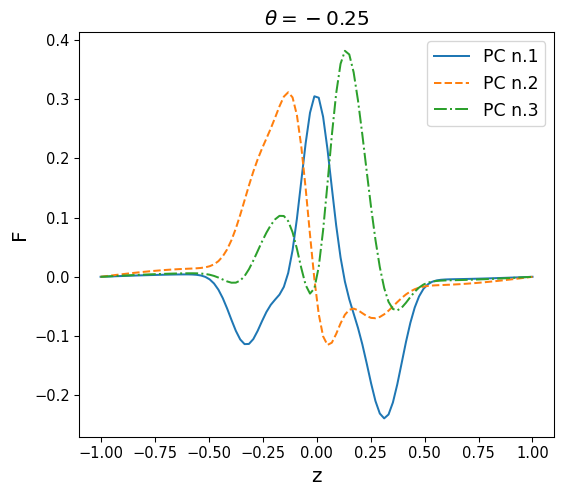

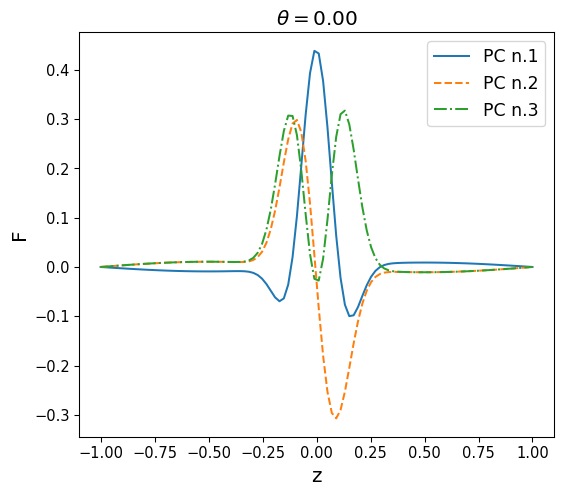

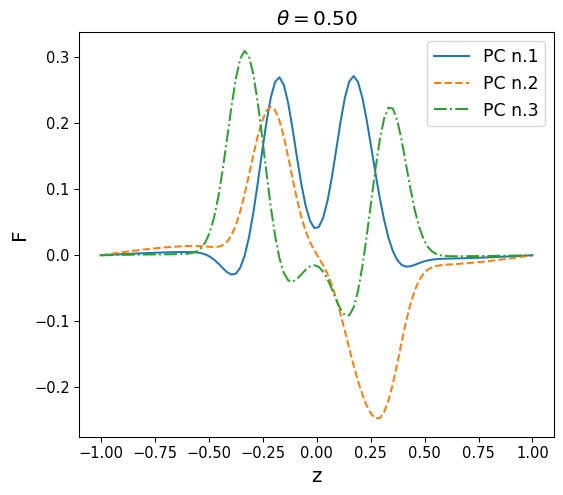

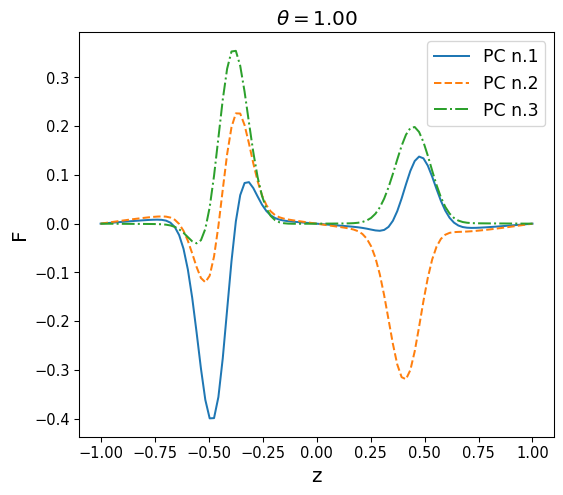

In [24]:
thetas = [-0.25, 0, 0.5, 1]
count = 0
for theta in thetas:
  P = grass.predict(theta)
  count +=1
  # P = pca.components_[:m].T
  my_dpi=96
  plt.figure(figsize=(613/my_dpi, 525/my_dpi), dpi=my_dpi)
  # plt.rc('figure', titlesize=15)
  plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
  plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
  plt.rc('legend', fontsize=13)    # legend fontsize
  lines = ['-','--','-.',':']
  for j in range(3):
    plt.plot(x, P[:,j], lines[j], label = 'PC n.%d' % (j+1))
  plt.title("$\\theta = %.2f$" % theta,fontsize=15)
  plt.xlabel("z")
  plt.ylabel("F")
  plt.legend()
  # plt.savefig('../plots_final/ex2/PCs/theta'+f'{count}grass',dpi=my_dpi)
  plt.show()

In [8]:
def Sdist_inf(A, B):
    U, S, Vh =np.linalg.svd(A.T@B, full_matrices=False)
    return np.sqrt(1-min(S)**2)

In [9]:
def variability(model,theta_test):
    distances = []
    for i in range(len(theta_test)//2):
        distances.append(Sdist_inf(model.predict(theta_test[2*i]),model.predict(theta_test[2*i+1])))

    return np.mean(distances), 1.96*np.sqrt(np.var(distances,ddof=1)/(len(theta_test)//2))

In [10]:
print(variability(grass,thetadata_test))
print(variability(kerpca,thetadata_test))
print(variability(ipca,thetadata_test))

(0.7102221521392174, 0.03520721237226333)
(0.7677717620932356, 0.03683722824567429)
(0.6105300475293117, 0.05888075261481769)
